In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.linear_model import LinearRegression
import subprocess
import sys
import time

In [2]:
os.chdir("../../")
training_dir = "training"
checkpoint_dir = f"{training_dir}/checkpoints"
model_dir = f"{training_dir}/models"
evaluator_dir = "analysis/src/evaluation/model"
analysis_dir = "data/analysis"

In [3]:
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f != "latest.json"])
checkpoints = [json.loads(json.load(open(f"{checkpoint_dir}/{file}"))[1]) for file in checkpoint_files]

model_files = sorted([f for f in os.listdir(model_dir) if f != "latest.json"])

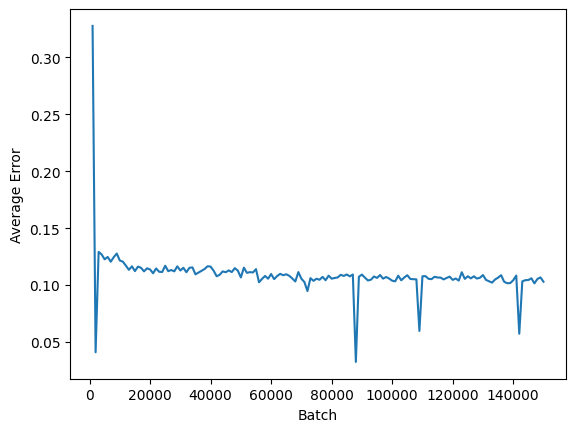

In [4]:
batch = np.array([c["batch"] for c in checkpoints])
error = np.array([c["error"] for c in checkpoints])

plt.plot(batch, error)
plt.xlabel("Batch")
plt.ylabel("Average Error")
plt.show()

In [5]:
def normalized(x):
    return x / max(abs(x))

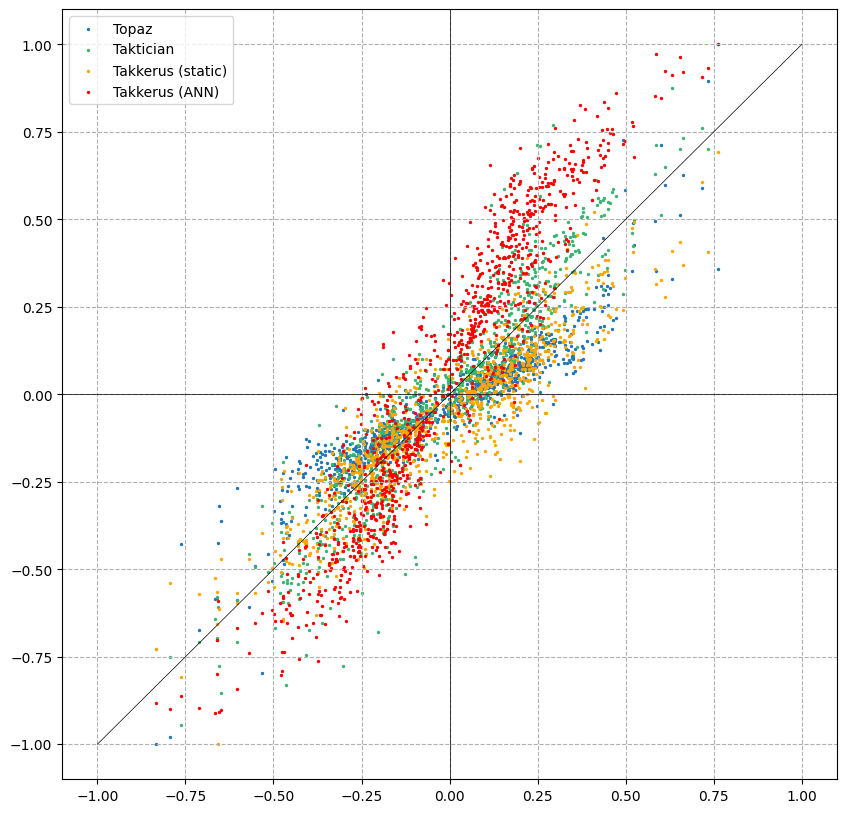

In [6]:
matplotlib.rc('figure', figsize=(10, 10))

subprocess.run(["cp", f"{model_dir}/latest.json", f"{evaluator_dir}/model_6s.json"])

takkerus_ann = normalized(np.array(json.loads(subprocess.run(
    ["cargo", "run", "--bin", "evaluate_positions", "--features", "tools", "--", "data/comparison_set.json"],
    capture_output=True,
    text=True,
).stdout)))

takkerus_static = normalized(np.array(json.load(open("data/takkerus_static_evaluations.json"))))
topaz = normalized(np.array(json.load(open("data/topaz_evaluations.json"))))
taktician = normalized(np.array(json.load(open("data/taktician_evaluations.json"))))

baseline = (takkerus_ann + takkerus_static + topaz + taktician) / 4.0

ax = plt.gca()
ax.grid(True, which="both", linestyle="--")
ax.axhline(color="black", linewidth=0.5)
ax.axvline(color="black", linewidth=0.5)

plt.plot([-1.0, 1.0], [-1.0, 1.0], linestyle="-", linewidth=0.5, color="black")
plt.scatter(baseline, topaz, s=2, label="Topaz", color="#1f77b4")
plt.scatter(baseline, taktician, s=2, label="Taktician", color="mediumseagreen")
plt.scatter(baseline, takkerus_static, s=2, label="Takkerus (static)", color="orange")
plt.scatter(baseline, takkerus_ann, s=2, label="Takkerus (ANN)", color="red")
plt.scatter
plt.legend(loc="upper left")
plt.show()

In [7]:
TOPAZ = "Topaz"
TAKTICIAN = "Taktician"
TAKKERUS_STATIC = "Takkerus (static)"
TAKKERUS_ANN = "Takkerus (ANN)"

match_result = r"\+(\d+)-(\d+)=(\d+)"

def load_model(file):
    subprocess.run(["cp", f"{model_dir}/{file}", f"{evaluator_dir}/model_6s.json"])
    subprocess.run(["cargo", "build", "--release"], capture_output=True)

def play_match(opponent, games):
    engine_1 = "target/release/takkerus"
    engine_1_args = "tei --ai depth=4"

    if opponent == TOPAZ:
        engine_2 = "../topaz-tak/target/release/topaz"
        engine_2_args = ""
    elif opponent == TAKTICIAN:
        engine_2 = "../taktician/taktician"
        engine_2_args = "tei"
    elif opponent == TAKKERUS_STATIC:
        engine_2 = "../takkerus/target/release/takkerus"
        engine_2_args = "tei --ai depth=4"
    elif opponent == TAKKERUS_ANN:
        engine_2 = engine_1
        engine_2_args = engine_1_args

    racetrack_dir = "../racetrack"

    p = subprocess.run([
        f"{racetrack_dir}/target/release/racetrack",
        "--engine", f"{engine_1}", f"{engine_2}",
        "--engine1-args", engine_1_args,
        "--engine2-args", engine_2_args,
        "--size", "6",
        "--komi", "0.0",
        "--concurrency", "4",
        "--games", str(games),
        "--tc", "600+20",
        "--book", f"{racetrack_dir}/6s_4ply_balanced_openings.txt",
        "--shuffle-book",
    ], capture_output=True, text=True)

    result = re.search(match_result, p.stdout.strip().split("\n")[-1])
    return result

In [ ]:
if os.path.exists(f"{analysis_dir}/topaz_matches.json"):
    match_results = json.load(open(f"{analysis_dir}/topaz_matches.json"))
else:
    match_results = []

while len(match_results) == 0 or match_results[-1][0] != model_files[-1]:
    if len(match_results) == 0:
        next_model = model_files[0]
    else:
        next_model = model_files[model_files.index(match_results[-1][0]) + 1]
        
    print(f"Beginning match: {next_model} vs {TOPAZ}")
    
    start = time.time()
    load_model(next_model)
    result = play_match(TOPAZ, 500)
    end = time.time()
    
    match_results.append([next_model, result.group(0)])
    print(f"  Match result: {result.group(0)}, {end - start:.2f}s")
    
    with open(f"{analysis_dir}/topaz_matches.json", "w") as f:
        f.write(json.dumps(match_results))

In [ ]:
if os.path.exists(f"{analysis_dir}/taktician_matches.json"):
    match_results = json.load(open(f"{analysis_dir}/taktician_matches.json"))
else:
    match_results = []

while len(match_results) == 0 or match_results[-1][0] != model_files[-1]:
    if len(match_results) == 0:
        next_model = model_files[0]
    else:
        next_model = model_files[model_files.index(match_results[-1][0]) + 1]
        
    print(f"Beginning match: {next_model} vs {TAKTICIAN}")
    
    start = time.time()
    load_model(next_model)
    result = play_match(TAKTICIAN, 500)
    end = time.time()
    
    match_results.append([next_model, result.group(0)])
    print(f"  Match result: {result.group(0)}, {end - start:.2f}s")
    
    with open(f"{analysis_dir}/taktician_matches.json", "w") as f:
        f.write(json.dumps(match_results))

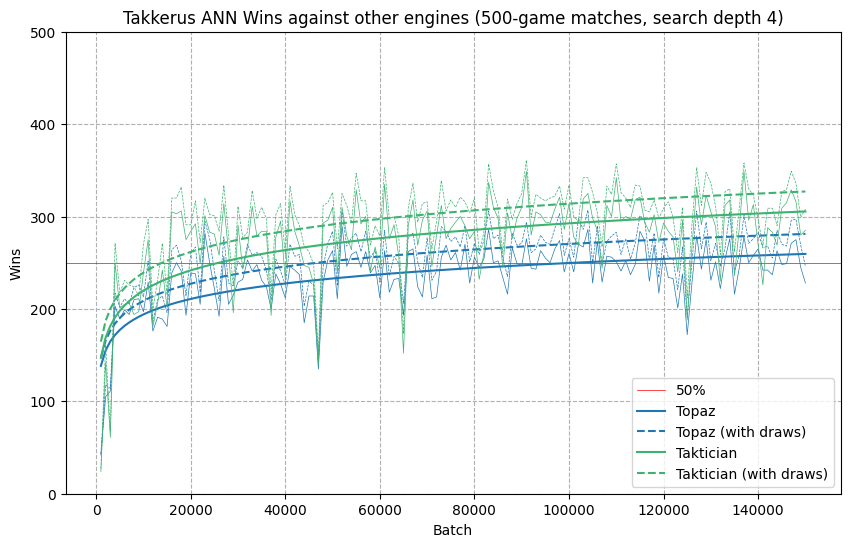

In [8]:
matplotlib.rc('figure', figsize=(10, 6))

def load_matches(file):
    return [
        [int(m.group(1)), int(m.group(2)), int(m.group(3))]
        for m in [re.match(match_result, r[1]) for r in json.load(open(file))]
    ]

x = np.log(batch.reshape(-1, 1))


topaz_matches = load_matches(f"{analysis_dir}/topaz_matches.json")
topaz_wins = np.array([m[0] for m in topaz_matches])
topaz_wins_and_draws = np.array([m[0] + m[2] for m in topaz_matches])

regression = LinearRegression().fit(x, topaz_wins)
topaz_wins_curve = regression.predict(x)

regression = LinearRegression().fit(x, topaz_wins_and_draws)
topaz_wins_and_draws_curve = regression.predict(x)

taktician_matches = load_matches(f"{analysis_dir}/taktician_matches.json")
taktician_wins = np.array([m[0] for m in taktician_matches])
taktician_wins_and_draws = np.array([m[0] + m[2] for m in taktician_matches])

regression = LinearRegression().fit(x[:len(taktician_matches)], taktician_wins)
taktician_wins_curve = regression.predict(x[:len(taktician_matches)])

regression = LinearRegression().fit(x[:len(taktician_matches)], taktician_wins_and_draws)
taktician_wins_and_draws_curve = regression.predict(x[:len(taktician_matches)])

ax = plt.gca()
ax.set_ylim([0, 500])
ax.grid(True, which="both", linestyle="--")
ax.axhline(y=250, color="red", linewidth=0.5, label="50%")

plt.plot(batch, topaz_wins, color="#1f77b4", linewidth=0.5)
plt.plot(batch, topaz_wins_and_draws, linestyle="--", color="#1f77b4", linewidth=0.5)
plt.plot(batch, topaz_wins_curve, color="#1f77b4", label="Topaz")
plt.plot(batch, topaz_wins_and_draws_curve, linestyle="--", color="#1f77b4", label="Topaz (with draws)")

plt.plot(batch, taktician_wins, color="mediumseagreen", linewidth=0.5)
plt.plot(batch, taktician_wins_and_draws, linestyle="--", color="mediumseagreen", linewidth=0.5)
plt.plot(batch, taktician_wins_curve, color="mediumseagreen", label="Taktician")
plt.plot(batch, taktician_wins_and_draws_curve, linestyle="--", color="mediumseagreen", label="Taktician (with draws)")

plt.title("Takkerus ANN Wins against other engines (500-game matches, search depth 4)")
plt.xlabel("Batch")
plt.ylabel("Wins")
plt.legend(loc="lower right")
plt.show()